In [285]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pcntoolkit as pcn
import pickle

import scipy.stats as stats

from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_subcortical
from enigmatoolbox.utils.useful import reorder_sctx

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom
from clinics_desc_functions import prepare_data, plot_quality, trajectory_plotting, dk_roi_viz, load_clinics, en_qc, pretrained_adapt, set_seed

# set seed
set_seed()

# formatiing
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}



Random seed 42 has been set.


In [333]:
# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long_adapt_experiment')
os.makedirs(models_dir, exist_ok=True)
cdata_dir = ('/home/barbora/Documents/Projects/2021_06_AZV_ESO/data')
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
bdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/backup/fit_external_long')
images_dir = os.path.join(models_dir,'img')
os.makedirs(models_dir, exist_ok=True)
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts')

In [334]:
####
# Getting a pretrained model
# ###
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [394]:
# load clinics from the first visit
c_v1 = pd.read_excel(os.path.join(cdata_dir,'visit1_desc.xlsx')) 
c_v1 = load_clinics(c_v1)
c_v1.index = c_v1.index.str.slice_replace(start=-2, repl='').to_numpy()

d_v1 = pd.read_csv(os.path.join(bdata_dir,'fit_external_thickness_1.txt'), delimiter=';', index_col=0)
d_v1.index = d_v1.index.str.slice_replace(start=-2, repl='').to_numpy()

v1_concat = pd.concat([c_v1, d_v1], axis=1, join="inner")
v1_concat["sitenum"] =1000

# load clinics from the second visit
c_v2 = pd.read_excel(os.path.join(cdata_dir,'visit2_desc.xlsx')) 
c_v2 = load_clinics(c_v2)
c_v2.index = c_v2.index.str.slice_replace(start=-2, repl='').to_numpy()

d_v2 = pd.read_csv(os.path.join(bdata_dir,'fit_external_thickness_2.txt'), delimiter=';',  index_col=0)
d_v2.index = d_v2.index.str.slice_replace(start=-2, repl='').to_numpy()

v2_concat = pd.concat([c_v2, d_v2], axis=1, join="inner")
v2_concat["sitenum"] =1000

In [395]:
###
# Quality control based on Euler Number
###
# in longitudinal data, we don't have information on the number of holes and ca't run the quality control based on Euler Number
long = 1

if long == 1:
    v1_clean = v1_concat
    v2_clean = v2_concat
else:
    save_img, img_dir, show_img = True, images_dir, False
    v1_clean = en_qc(v1_concat, save_img=save_img, img_dir=img_dir, show_img=show_img)
    v2_clean = en_qc(v2_concat, save_img=save_img, img_dir=img_dir, show_img=show_img)

In [396]:
# Splitting datasets
v1_pat = v1_clean[v1_clean['Category']=='Patient']
v1_cont = v1_clean[v1_clean['Category']=='Control']
#v1_cont_train = v1_cont.sample(frac = 0.5)
#v1_cont_ad = v1_cont.drop(v1_cont_train.index)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(v1_pat['site'].to_list()))

v2_pat = v2_clean[v2_clean['Category']=='Patient']
v2_cont = v2_clean[v2_clean['Category']=='Control']
#v2_cont_train = v2_cont.sample(frac = 0.5)
#v2_cont_ad = v2_cont.drop(v2_cont_train.index)

v1_pat = v1_pat.sort_index()
v2_pat = v2_pat.sort_index()

# write for future use
#v1_pat.to_csv(os.path.join(models_dir, 'v1_pat.txt'), sep=' ', index=True)
#v2_pat.to_csv(os.path.join(models_dir, 'v2_pat.txt'), sep=' ', index=True)

In [14]:
print(v1_pat.groupby('sex').agg(['count','mean'])['age'])
print(v1_cont.groupby('sex').agg(['count','mean'])['age'])

     count       mean
sex                  
0       44  28.935682
1       75  26.838667
     count       mean
sex                  
0       43  30.183953
1       27  29.736296


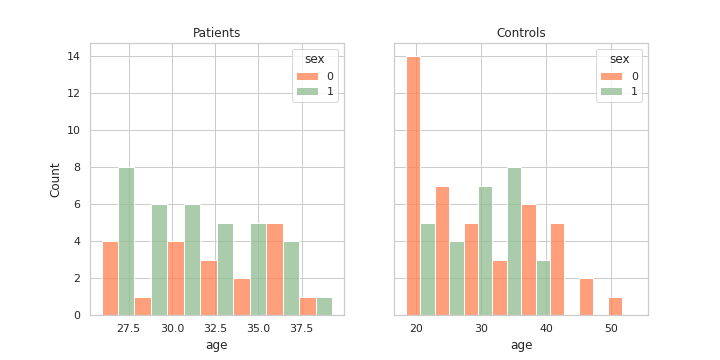

In [311]:
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))

sns.set_style("whitegrid")
to_plot = pd.concat([v1_pat[['age','sex','Category']],v1_cont[['age','sex','Category']]])

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
#sns.histplot(data=v1_pat, x='age', hue='sex',  stat='probability', ax=ax[0], palette = fm_palette, multiple='dodge')
sns.histplot(data=v1_pat, x='age', hue='sex', ax=ax[0], palette = fm_palette, multiple='dodge')
ax[0].set_title('Patients')
#sns.histplot(data=v1_cont, x='age', hue='sex',  stat='probability', ax=ax[1], palette = fm_palette, multiple='dodge')
sns.histplot(data=v1_cont, x='age', hue='sex',  ax=ax[1], palette = fm_palette, multiple='dodge')
ax[1].set_title('Controls')
fig.savefig(os.path.join(models_dir, 'hist_data_distribution_age_sex'))

In [386]:
def equalize2(data1, data2):
    """
    data1, data2 = equalize2(data1, data2)
    put into two 2D numpy arrays (containing the variables you wan to "make equal")
    the function will identify subjects that need to be removed and inserts NaN-s to their respective positions
    - this function primarily removes subjects from the bigger dataset
    """
    from scipy.stats import ttest_ind
    
    alpha = 0.05
    Nvars = data1.shape[1]
    OK=0
    N1 = data1.shape[0]
    N2 = data2.shape[0]

    # one sided test to check for differences
    [h,p] = ttest_ind(data1, data2, alternative='greater')
    p2 = np.min(np.concatenate([p, 1-p]))

    if p2 > alpha:
        OK = 1
    
    while OK == 0:
        # pick the variable with the most significant effect
        I = np.where(p2==np.min(p2))[0]
        direction = p[I[0]]<0.05 # check the direction of the effect

        N1 = sum(~np.isnan(data1[:,0]))
        N2 = sum(~np.isnan(data2[:,0]))

        largerN1 = N1>N2

        if largerN1:
            if direction:
                IN = np.where(data1[:,I[0]]==np.nanmax(data1[:,I[0]]))[0] # index for removal
            else:
                IN = np.where(data1[:,I[0]]==np.nanmin(data1[:,I[0]]))[0] # index for removal

            data1[IN[0],:] = np.nan
            print('removing from dataset 1:',str(IN[0]))
        else:
            if direction:
                IN = np.where(data2[:,I[0]]==np.nanmin(data2[:,I[0]]))[0] # index for removal
            else:
                IN = np.where(data2[:,I[0]]==np.nanmax(data2[:,I[0]]))[0] # index for removal

            data2[IN[0],:] = np.nan
            print('removing from dataset 2:',str(IN[0]))

        [h,p] = ttest_ind(data1[~np.isnan(data1[:,0]),:], data2[~np.isnan(data2[:,0]),:], alternative='greater')
        p2 = np.min(np.concatenate([p, 1-p])) # ttest in all variables

        if np.min(np.concatenate([p, 1-p])) > alpha:
            OK=1

    return(data1, data2)


In [397]:
remove_pat, remove_cont = equalize2(v1_pat[['age', 'sex']].to_numpy(), v1_cont[['age', 'sex']].to_numpy())
#remove_pat, remove_cont = equalize1(v1_pat[['age', 'sex']].to_numpy(), v1_cont[['age', 'sex']].to_numpy())

remove_pat_index = v1_pat.iloc[np.where(np.isnan(remove_pat[:,0]))[0],:].index
remove_cont_index = v1_cont.iloc[np.where(np.isnan(remove_cont[:,0]))[0],:].index

v1_pat_prune = v1_pat.drop(index=remove_pat_index)
v2_pat_prune = v2_pat.drop(index=remove_pat_index)

v1_cont_prune = v1_cont.drop(index=remove_cont_index)
v2_cont_prune = v2_cont.drop(index=remove_cont_index)

#models_dir = os.path.join(models_dir,'equalized_1_1')
models_dir = os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long_adapt_experiment','equalized_controls_deleted')
os.makedirs(models_dir, exist_ok=True)


removing from dataset 1: 0
removing from dataset 1: 116
removing from dataset 1: 78
removing from dataset 1: 13
removing from dataset 1: 82
removing from dataset 1: 25
removing from dataset 1: 94
removing from dataset 1: 68
removing from dataset 1: 56
removing from dataset 1: 61
removing from dataset 1: 86
removing from dataset 1: 117
removing from dataset 1: 97
removing from dataset 1: 26
removing from dataset 1: 15
removing from dataset 1: 19
removing from dataset 1: 38
removing from dataset 1: 65
removing from dataset 1: 109
removing from dataset 1: 36
removing from dataset 1: 114
removing from dataset 1: 11
removing from dataset 1: 48
removing from dataset 1: 47
removing from dataset 1: 99
removing from dataset 1: 53
removing from dataset 1: 59
removing from dataset 1: 103
removing from dataset 1: 66
removing from dataset 1: 112
removing from dataset 1: 93
removing from dataset 1: 40
removing from dataset 1: 113
removing from dataset 1: 115
removing from dataset 1: 96
removing from

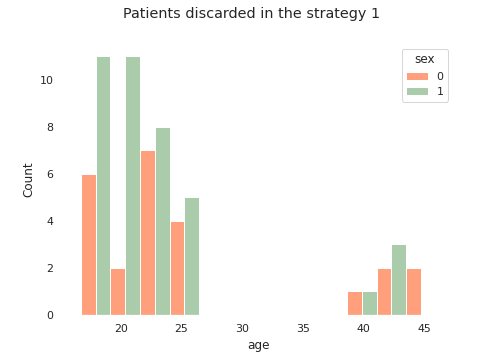

In [409]:
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))
pk = v1_pat.loc[remove_pat_index]
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.histplot(data=pk, x='age', hue='sex',  palette = fm_palette, multiple='dodge')
fig.suptitle('Patients discarded in the strategy 1')
plt.savefig('/home/barbora/Documents/Projects/Normative_Models/ESO/models/pretrained_long_adapt_experiment/equalized_1_1/discarded')


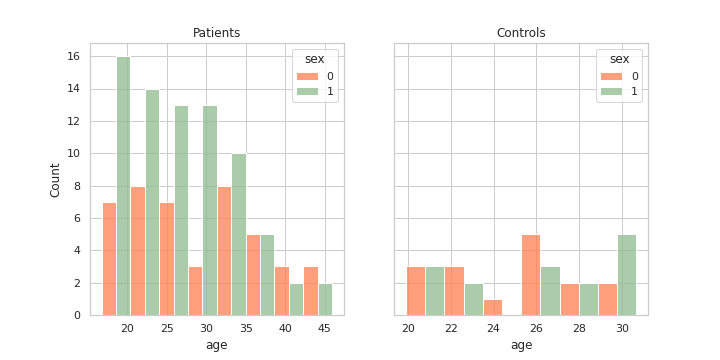

In [344]:
FM_colors = ["coral", "darkseagreen"]
fm_palette = sns.set_palette(sns.color_palette(FM_colors))

sns.set_style("whitegrid")
to_plot = pd.concat([v1_pat[['age','sex','Category']],v1_cont[['age','sex','Category']]])

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
#sns.histplot(data=v1_pat, x='age', hue='sex',  stat='probability', ax=ax[0], palette = fm_palette, multiple='dodge')
sns.histplot(data=v1_pat_prune, x='age', hue='sex', ax=ax[0], palette = fm_palette, multiple='dodge')
ax[0].set_title('Patients')
#sns.histplot(data=v1_cont, x='age', hue='sex',  stat='probability', ax=ax[1], palette = fm_palette, multiple='dodge')
sns.histplot(data=v1_cont_prune, x='age', hue='sex',  ax=ax[1], palette = fm_palette, multiple='dodge')
ax[1].set_title('Controls')
fig.savefig(os.path.join(models_dir, 'hist_pruned_data_distribution_age_sex'))

In [345]:
###
# Configure covariates
###

# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

In [348]:
# Which visit do we wanto to analyse?
visit = 2
visit_dir = os.path.join(models_dir,'V'+str(visit))
os.makedirs(visit_dir, exist_ok=True)

if visit==1:
    df_ad = v1_cont_prune
    df_te = v1_pat_prune
    
    v1_cont_prune.to_csv(os.path.join(visit_dir,'v1_cont.txt'), sep=' ')
    v1_pat_prune.to_csv(os.path.join(visit_dir,'v1_pat.txt'), sep=' ')

elif visit == 2:
    df_ad = v1_cont_prune
    df_te = v2_pat_prune

    v2_cont_prune.to_csv(os.path.join(visit_dir,'v2_cont.txt'), sep=' ')
    v2_pat_prune.to_csv(os.path.join(visit_dir,'v2_pat.txt'), sep=' ')


In [349]:
pretrained_adapt(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_te)

Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Some sites missing from the training data. Adapt

In [38]:
###
# Preparing dummy data for plotting
###

# which sex do we want to plot? 
sex = 1 # 1 = male 0 = female
if sex == 1: 
    clr = 'blue'
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx # intercept
X0_dummy[:,1] = sex # sex covariate

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, site_ids=None, all_sites=site_ids_tr)

# save the dummy covariates
cov_file_dummy = os.path.join(models_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


In [39]:
###
# Plotting normative models
###

sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(pretrained_dir,'models',model_name, idp)
    idp_visit_dir = os.path.join(visit_dir,idp)
    os.chdir(idp_visit_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_visit_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_visit_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_visit_dir, 'resp_te.txt'))
    X_te = load_2d(os.path.join(idp_visit_dir, 'cov_bspline_te.txt'))
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    
    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set
            
            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue
            
            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 
            
            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]
            
            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_visit_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_visit_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue
            
            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
            
            # save transformed predictions so that we don't have to sompute this ever again
            y_te_rescaled_f = os.path.join(idp_visit_dir,'y_rescaled_'+str(sex)+'.txt')
            np.savetxt(y_te_rescaled_f,y_te_rescaled)

            #s2_rescaled_f = os.path.join(idp_visit_dir,'s2_rescaled_'+str(sex)+'.txt')
            #np.savetxt(s2_rescaled_f,s2_rescaled)

        # plot the (adjusted) data points
        plt.scatter(X_te[idx,1], y_te_rescaled, s=4, color=clr, alpha = 0.5)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((10,60))
    plt.savefig(os.path.join('centiles_' + str(sex)),  bbox_inches='tight')
    plt.close()

os.chdir(idp_visit_dir)

Running IDP 0 lh_G&S_frontomargin_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.12692285]), 'Rho': array([0.31274562]), 'pRho': array([0.00049191]), 'SMSE': array([1.00016164]), 'EXPV': array([0.09756818])}
Running IDP 1 lh_G&S_occipital_inf_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.1399973]), 'Rho': array([0.2657479]), 'pRho': array([0.00336161]), 'SMSE': array([0.94159904]), 'EXPV': array([0.06243396])}
Running IDP 2 lh_G&S_paracentral_thickness :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.13955376]), 'Rho': array([-0.03473396]), 'pRho': array([0.70822073]), 'SMSE': array([1.14724895]), 'EXPV': array([-0.10343739])}
Running IDP 3 lh_G&S_s

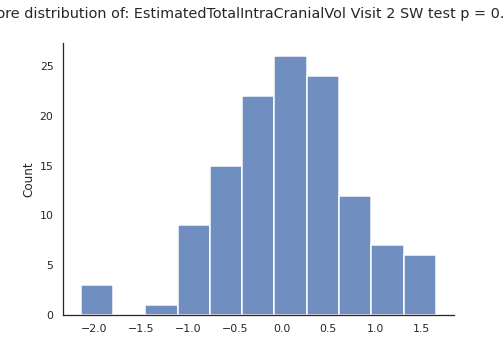

In [72]:
to_load=os.path.join(visit_dir, idp, 'Z_predict.txt')
z_score = pd.read_csv(to_load, header=None)

# Description of the clinics - Visit 1
stat,p = shapiro(z_score)

sns.set_style("white")
fig, axes = plt.subplots(1, figsize=(7,5))
fig.suptitle('Z_score distribution of: '+ idp+ ' Visit ' +str(visit)+ ' SW test p = '+str(round(p,ndigits=4)))
sns.histplot(data=z_score, alpha=.8, linewidth=1.5, legend=False)
sns.despine()



In [199]:
v1_pat.shape

(239, 221)

In [73]:
# Copy all Z-scores files into one directory in bash, then continue with this script
z_dir = os.path.join(visit_dir,'deviation_scores')
filelist = [name for name in os.listdir(z_dir)]
os.chdir(z_dir)
Z_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)
Z_df.index = df_te.index

In [74]:
# Merge and save the data
df_te_Z = pd.merge(df_te, Z_df, how='inner', left_index=True, right_index=True)
df_te_Z.to_csv(os.path.join(visit_dir,'te_Z.csv'), index=True)

**Checking the fit**
--------------------

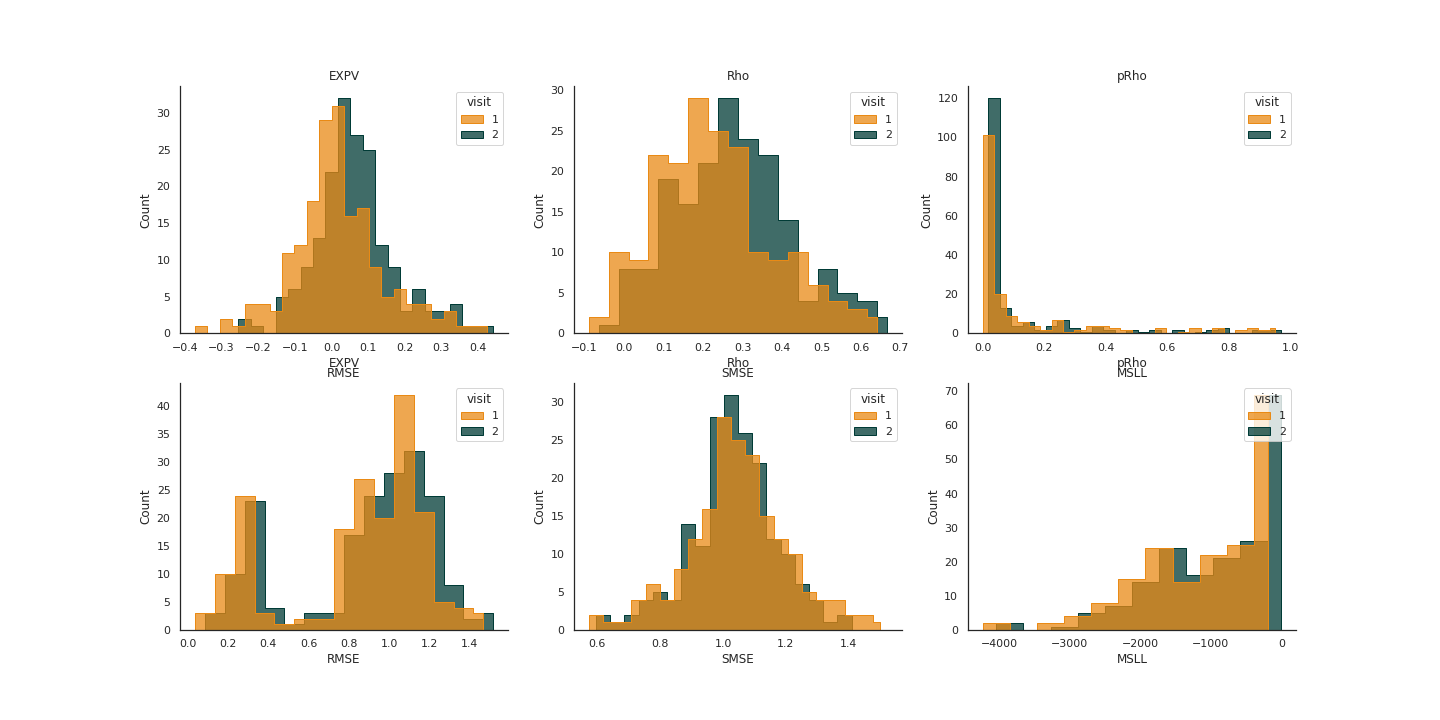

In [351]:
# Concatenate and plot quality measures of fitted models
v1_qm,quality_measures = custom.idp_concat_quality(os.path.join(models_dir,'V1'), idp_ids)
v1_qm['visit'] = '1'
v2_qm,quality_measures = custom.idp_concat_quality(os.path.join(models_dir,'V2'), idp_ids)
v2_qm['visit'] = '2'

qm = pd.concat([v1_qm, v2_qm]).reset_index()

visit_colors = ["#E98A15", "#003B36"]


sns.set_style("white")
fig, ax = plt.subplots(2,3, figsize=(20,10))

for iplot in range(6):
    x = int(np.floor(iplot/3))
    y = np.mod(iplot,3)
    sns.histplot(data = qm, x=quality_measures[iplot], hue='visit', element='step', ax=ax[x,y], palette=sns.color_palette(visit_colors), multiple='dodge')
    ax[x,y].set_title(quality_measures[iplot])

sns.despine()
plt.savefig(os.path.join(models_dir, 'quality_measures'),  bbox_inches='tight')

In [354]:
import prepare_models_for_analysis
import shutil

files = ['v1_pat.txt', 'v2_pat.txt']
shutil.copy(os.path.join(models_dir, 'V1', 'v1_pat.txt'), os.path.join(models_dir, 'v1_pat.txt'))
shutil.copy(os.path.join(models_dir, 'V2', 'v2_pat.txt'), os.path.join(models_dir, 'v2_pat.txt'))

controls_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long')

prepare_models_for_analysis.prepare_models_for_analysis(models_dir, controls_dir, models_dir)
v1_pat = pd.read_csv(os.path.join(models_dir,'v1_pat.txt'), sep=' ', index_col=0)
v2_pat = pd.read_csv(os.path.join(models_dir,'v2_pat.txt'), sep=' ', index_col=0)
    

Random seed 42 has been set.


In [355]:
# identify rows with missing clinical variables
clin_id = [i for i in v1_pat.columns if ('PANSS' in i) or ('GAF' in i)]

missing1 = list(dict.fromkeys(np.where(np.isnan(v1_pat[clin_id]))[0]))
missing2 = list(dict.fromkeys(np.where(np.isnan(v2_pat[clin_id]))[0]))
missing1.extend(missing2)
missing = list(dict.fromkeys(missing1))

In [356]:
# drop the rows
v1_pat = v1_pat.drop(v1_pat.iloc[missing].index)
v2_pat = v2_pat.drop(v2_pat.iloc[missing].index)
print(str(len(missing)),' patients were deleted')

3  patients were deleted


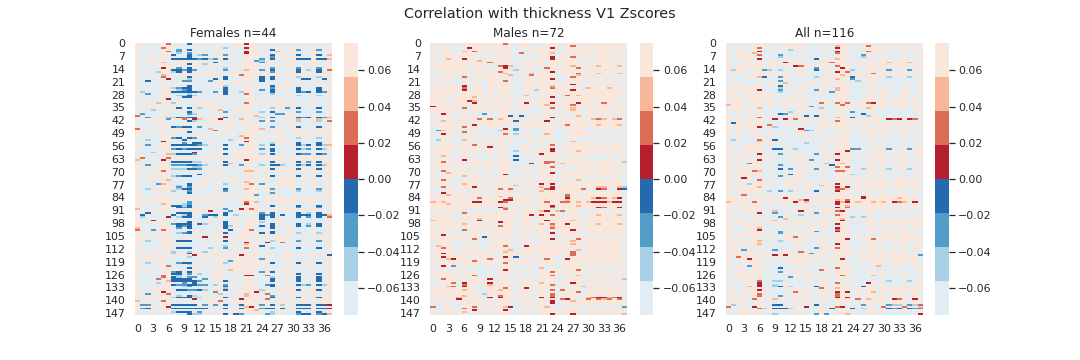

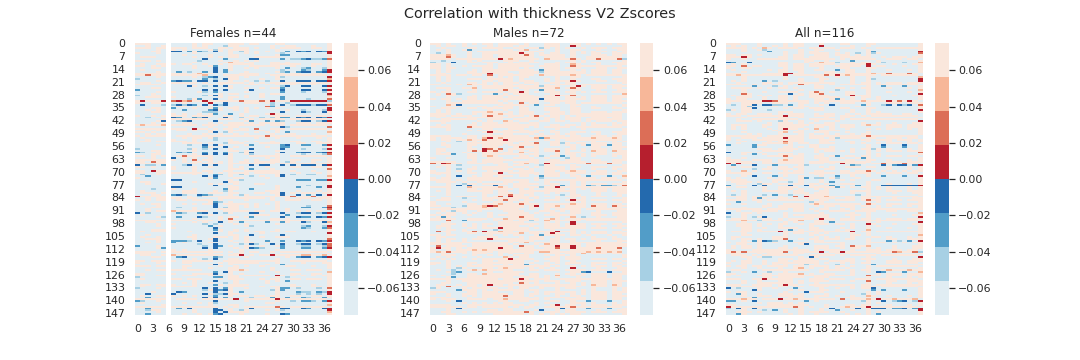

In [357]:
# Compute correlation of thickness zscores with clinical scales across sex
pk = sns.color_palette("RdBu_r", 8)
dcsc = sns.color_palette("RdBu_r", 8)
dcsc[0] = pk[3]
dcsc[1] = pk[2]
dcsc[2] = pk[1]
dcsc[3] = pk[0]
dcsc[4] = pk[7]
dcsc[5] = pk[6]
dcsc[6] = pk[5]
dcsc[7] = pk[4]


sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

thick_id = [i for i in v1_pat.columns if 'thickness' in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    spearman_f = custom.spearman_matrices(cmat[thick_id].loc[f], cmat[clin_id].loc[f])
    spearman_m = custom.spearman_matrices(cmat[thick_id].loc[m], cmat[clin_id].loc[m])
    spearman_all = custom.spearman_matrices(cmat[thick_id], cmat[clin_id])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation with thickness V'+str(i)+' Zscores')
    plt.savefig(os.path.join(models_dir, 'heatmaps_thickness_zscore_v'+str(i)))

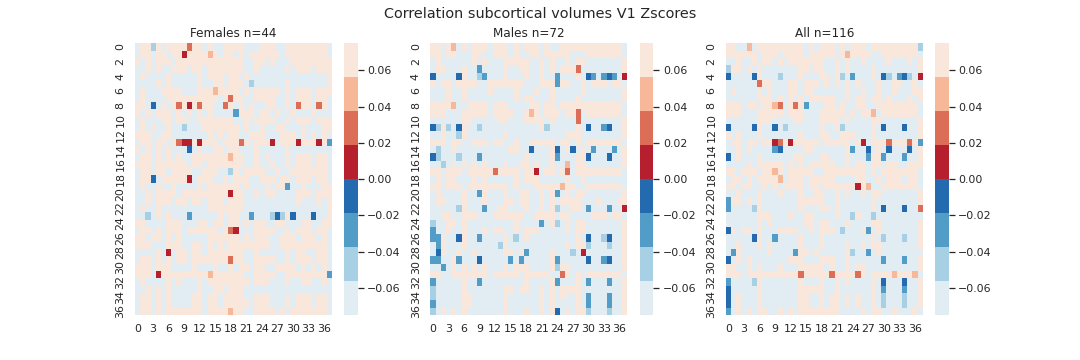

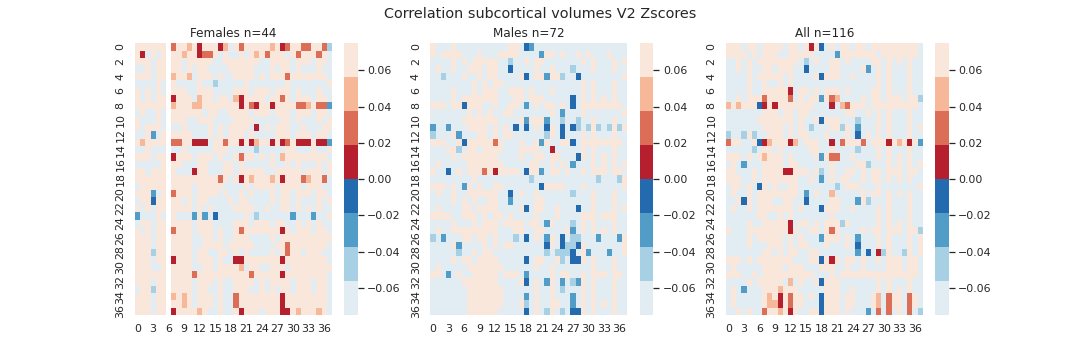

In [358]:
# Compute correlation of thickness with clinical scales across sex
sc_id = [i for i in idp_ids if 'thickness' not in i]
f = v1_pat.index[v1_pat['sex']==0]
m = v1_pat.index[v1_pat['sex']==1]

for i in range(1,3):
    if i==1:
        cmat = v1_pat
    else:
        cmat = v2_pat

    spearman_f = custom.spearman_matrices(cmat[sc_id].loc[f], cmat[clin_id].loc[f])
    spearman_m = custom.spearman_matrices(cmat[sc_id].loc[m], cmat[clin_id].loc[m])
    spearman_all = custom.spearman_matrices(cmat[sc_id], cmat[clin_id])

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    sns.heatmap(spearman_f[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[0])
    ax[0].set_title('Females n='+str(len(f)))
    sns.heatmap(spearman_m[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[1])
    ax[1].set_title('Males n='+str(len(m)))
    sns.heatmap(spearman_all[2], cmap=dcsc, vmin=-0.075, vmax=0.075, ax=ax[2])
    ax[2].set_title('All n='+str(len(f)+len(m)))
    fig.suptitle('Correlation subcortical volumes V'+str(i)+' Zscores')
    plt.savefig(os.path.join(models_dir, 'heatmaps_sc_volumes_zscore_v'+str(i)))

In [359]:
v1_pat_all = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data/v1_pat.txt', sep=' ', index_col=0)
v2_pat_all = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data/v2_pat.txt', sep=' ', index_col=0)

In [360]:
remove_pat_index = v1_pat_all.iloc[np.where(~v1_pat_all.index.isin(v1_pat.index))[0],:].index

v1_pat_all.drop(index=remove_pat_index, inplace=True)
v2_pat_all.drop(index=remove_pat_index, inplace=True)

Text(0.5, 0.98, 'Example of z-scores of an example patient')

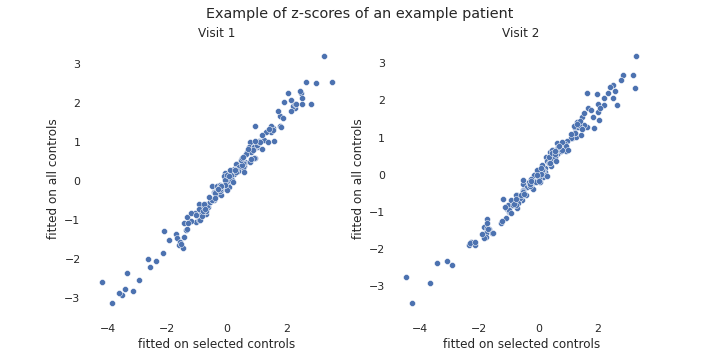

In [361]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(v1_pat[idp_ids].iloc[0], v1_pat_all[idp_ids].iloc[0], ax=ax[0])
ax[0].set_title('Visit 1')
ax[0].set_xlabel('fitted on selected controls')
ax[0].set_ylabel('fitted on all controls')
sns.scatterplot(v2_pat[idp_ids].iloc[0], v2_pat_all[idp_ids].iloc[0], ax=ax[1])
ax[1].set_title('Visit 2')
ax[1].set_xlabel('fitted on selected controls')
ax[1].set_ylabel('fitted on all controls')
fig.suptitle('Example of z-scores of an example patient')

116

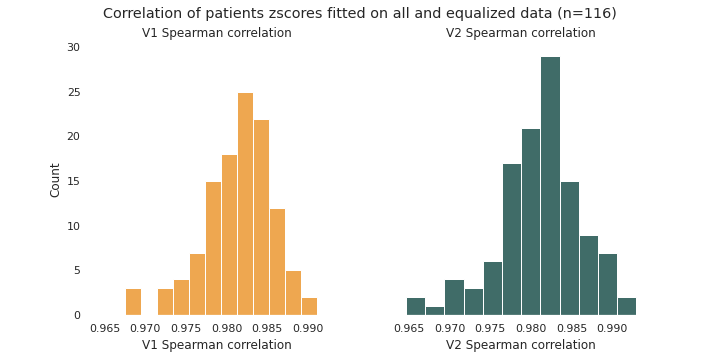

In [366]:
visit_colors = ["#E98A15", "#003B36"]
v1_intracorr = stats.spearmanr(v1_pat[idp_ids].transpose().to_numpy(),v1_pat_all[idp_ids].transpose().to_numpy())
v2_intracorr = stats.spearmanr(v2_pat[idp_ids].transpose().to_numpy(),v2_pat_all[idp_ids].transpose().to_numpy())


fig,ax=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.histplot(np.diag(v1_intracorr[0][0:v1_pat.shape[0],v1_pat.shape[0]:]), ax=ax[0], color=visit_colors[0])
ax[0].set_xlabel('V1 Spearman correlation')
ax[0].set_title('V1 Spearman correlation')

sns.histplot(np.diag(v2_intracorr[0][0:v1_pat.shape[0],v1_pat.shape[0]:]), ax=ax[1], color=visit_colors[1])
ax[1].set_xlabel('V2 Spearman correlation')
ax[1].set_title('V2 Spearman correlation')
fig.suptitle('Correlation of patients zscores fitted on all and equalized data (n='+str(v1_pat.shape[0])+')')

plt.savefig(os.path.join(models_dir, 'zscores corr histogram'))

In [321]:
def equalize1(data1, data2):
    """
    data1, data2 = equalize1(data1, data2)
    put into two 2D numpy arrays (containing the variables you wan to "make equal")
    the function will identify subjects that need to be removed and inserts NaN-s to their respective positions
    - this function ONLY removes subjects from DATA2
    """
    from scipy.stats import ttest_ind
    
    alpha = 0.05
    Nvars = data1.shape[1]
    OK=0
    N1 = data1.shape[0]
    N2 = data2.shape[0]

    # one sided test to check for differences
    [h,p] = ttest_ind(data1, data2, alternative='greater')
    p2 = np.min(np.concatenate([p, 1-p]))

    if p2 > alpha:
        OK = 1
    
    while OK == 0:
        # pick the variable with the most significant effect
        I = np.where(p2==np.min(p2))[0]
        direction = p[I[0]]<0.05 # check the direction of the effect
  
        if direction:
            IN = np.where(data2[:,I[0]]==np.nanmin(data2[:,I[0]]))[0] # index for removal
        else:
            IN = np.where(data2[:,I[0]]==np.nanmax(data2[:,I[0]]))[0] # index for removal

        data2[IN[0],:] = np.nan
        print('removing from dataset 2:',str(IN[0]))

        [h,p] = ttest_ind(data1[~np.isnan(data1[:,0]),:], data2[~np.isnan(data2[:,0]),:], alternative='greater')
        p2 = np.min(np.concatenate([p, 1-p])) # ttest in all variables

        if np.min(np.concatenate([p, 1-p])) > alpha:
            OK=1

    return(data1, data2)


In [322]:
pk1, pk2 = equalize1(v1_pat[['age','sex']].to_numpy(), v1_cont[['age', 'sex']].to_numpy())

removing from dataset 2: 50
removing from dataset 2: 57
removing from dataset 2: 58
removing from dataset 2: 65
removing from dataset 2: 40
removing from dataset 2: 49
removing from dataset 2: 35
removing from dataset 2: 60
removing from dataset 2: 52
removing from dataset 2: 38
removing from dataset 2: 54
removing from dataset 2: 62
removing from dataset 2: 37
removing from dataset 2: 59
removing from dataset 2: 68
removing from dataset 2: 36
